# COMP5329 A2 Competition
### Authors:
Calvin Li (490236424)
Warner Wang ()
Theresa Wang (490388169)

## Housekeeping

#### Packages Importation

In [1]:
import os
import re
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# NLTK imports
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, Dropout, GlobalAveragePooling2D,
                                     Concatenate)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB2
from tensorflow.keras.metrics import Metric
from tensorflow.keras.utils import register_keras_serializable

# PyTorch imports if needed (not used in any example so consider removing if not needed)
import torch


2024-05-09 02:17:54.601544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 02:17:54.601642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 02:17:54.779055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
# Configuration
MAX_CAPTION_LENGTH = 50
VOCAB_SIZE = 10000
EMBEDDING_DIM = 256
NUM_CLASSES = 18
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001

## Data preperation

### Train Val Split

In [4]:
DIR = '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset'
TRAIN_FILENAME = os.path.join(DIR, "train.csv")
TEST_FILENAME = os.path.join(DIR, "test.csv")
IMAGES_DIR = os.path.join(DIR, "data")
with open(TRAIN_FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    data_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
    
with open(TEST_FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")


# Read and preprocess data
data_df['image_path'] = data_df['ImageID'].apply(lambda x: os.path.join(IMAGES_DIR, x))

# Split data into training and validation sets
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=5329)
train_captions = train_df['Caption'].values
val_captions = val_df['Caption'].values
train_df.head()

,ImageID,Labels,Caption,image_path
22192,22195.jpg,1 5,A row of parked airplanes sitting on top of a ...,/kaggle/input/multi-label-classification-compe...
26142,26145.jpg,1 3,A group of female playing soccer on a soccer f...,/kaggle/input/multi-label-classification-compe...
2183,2183.jpg,1,A woman is skiing down a snowy slope with moun...,/kaggle/input/multi-label-classification-compe...
27323,27326.jpg,1,A runner sliding onto base while another playe...,/kaggle/input/multi-label-classification-compe...
721,721.jpg,1,A man in a baseball uniform getting ready to b...,/kaggle/input/multi-label-classification-compe...


#### Display the image data

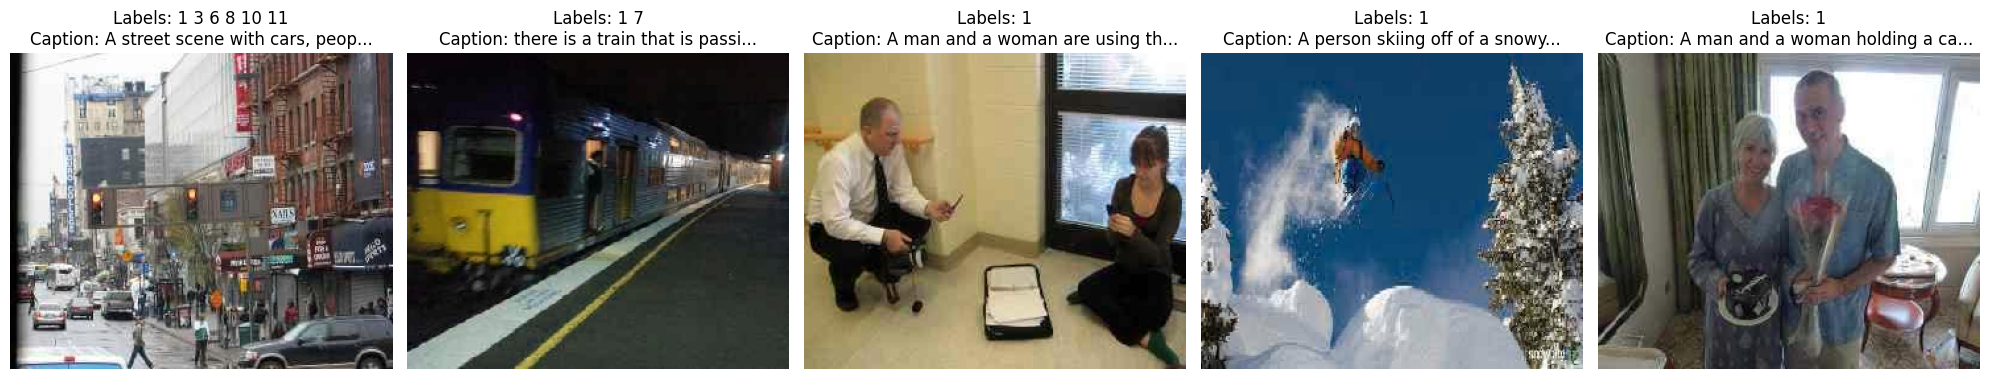

In [36]:
def show_images_with_labels_and_captions(df, num_images=5, img_height = 240, img_width = 290):
    """
    Displays images with their corresponding labels and captions.
    
    Parameters:
    - df: DataFrame containing the image paths, labels, and captions.
    - num_images: Number of images to display.
    """
    # Randomly select a few rows from the dataframe
    sample_df = df.sample(n=num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))  # Adjust size as needed
    axes = axes.flatten()

    for ax, idx in zip(axes, sample_df.index):
        row = sample_df.loc[idx]
        img = load_img(row['image_path'], target_size=(img_height, img_width))  # Load and resize the image
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Labels: {row['Labels']}\nCaption: {row['Caption'][:30]}...", fontsize=12)  # Show labels and part of the caption

    plt.tight_layout()
    plt.show()

# Example usage
np.random.seed(5329)
show_images_with_labels_and_captions(train_df, num_images=5)

### Tokenize Caption

In [37]:
!mkdir nltk_data

mkdir: cannot create directory 'nltk_data': File exists


In [38]:
# List of NLTK resources you need
nltk_resources = ['omw-1.4', 'stopwords', 'wordnet']

# Function to download necessary NLTK resources
def download_nltk_resources(resources):
    for resource in resources:
        try:
            nltk.data.find(resource)
        except LookupError:
            nltk.download(resource, "/kaggle/working/nltk_data/")  # Downloads the correct resource

# Download necessary resources
download_nltk_resources(nltk_resources)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# Manually unzip the WordNet resource if it's not being properly handled
wordnet_path = '/kaggle/working/nltk_data/corpora/wordnet.zip'
extract_path = '/kaggle/working/nltk_data/corpora/'
omw_path = '/kaggle/working/nltk_data/corpora/omw-1.4.zip'

with zipfile.ZipFile(wordnet_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

with zipfile.ZipFile(omw_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
# Now you can safely load stopwords and use wordnet
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

In [10]:
# Set the NLTK data path to include the directory where the resources are stored
nltk.data.path.append('/kaggle/working/nltk_data')

# Stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def caption_extract(captions):
    processed_captions = []
    for caption in captions:
        caption = caption.lower()
        caption = re.sub(r'[^a-z\s]', '', caption)  # Improved regex to remove non-alphabetic characters
        words = caption.split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        processed_captions.append(words)
    return processed_captions

train_captions = caption_extract(train_df['Caption'])
val_captions = caption_extract(val_df['Caption'])

# Tokenization and Padding Captions
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<UNK>')
tokenizer.fit_on_texts(train_captions)
train_sequences = tokenizer.texts_to_sequences(train_captions)
val_sequences = tokenizer.texts_to_sequences(val_captions)
train_captions_padded = pad_sequences(train_sequences, maxlen=MAX_CAPTION_LENGTH, padding='post')
val_captions_padded = pad_sequences(val_sequences, maxlen=MAX_CAPTION_LENGTH, padding='post')

### Label Encoding

Convert the labels from lists to a binary format suitable for multi-label classification. 

In [16]:
# Binarize labels
# Binarize labels and merge back into the DataFrame
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_df['Labels'].apply(lambda x: x.split()))
val_labels = mlb.transform(val_df['Labels'].apply(lambda x: x.split()))


In [5]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image

# TensorFlow Datasets
def create_tf_dataset(image_paths, labels, captions):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    caption_ds = tf.data.Dataset.from_tensor_slices(captions)
    
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = tf.data.Dataset.zip((image_ds, caption_ds, label_ds))
    
    def prepare_features(images, captions, labels):
        return {'input_layer': images, 'input_caption': captions}, labels

    return dataset.map(prepare_features, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize Dataset
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds




In [17]:
# Create Train and Validation TensorFlow Datasets
train_ds = create_tf_dataset(train_df['image_path'].values, train_labels, train_captions_padded)
val_ds = create_tf_dataset(val_df['image_path'].values, val_labels, val_captions_padded)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Model Architecture

In [18]:
@register_keras_serializable()
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return tf.cond(
            tf.equal(p + r, 0),
            lambda: 0.0,
            lambda: 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
        )

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras import backend as K
@register_keras_serializable()
def focal_loss(gamma=2., alpha=0.4):
    gamma = float(gamma)
    alpha = float(alpha)
    @register_keras_serializable()
    def focal_loss_fixed(y_true, y_pred):
        """The focal loss itself."""
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)

        ce = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = (1.0 - p_t) ** gamma
        loss = alpha_factor * modulating_factor * ce
        return K.mean(loss)
      
    return focal_loss_fixed

### EffcientNet

Embedding: 用pretain -- glove embeddings

LSTM可以换成 pre trained Bert

EfficientNet -- 冻结batch norm， 冻结前两层stage

Focal Loss 可以改成 Asymmetric Loss for MLC

swim transformer, convnext
clip 



In [46]:
K.clear_session()

In [19]:
# Load EfficientNet B0 without the top classification layer
def create_efficientnet():
    base_model = EfficientNetB2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    base_model.trainable = True   # Freeze the model weights / False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Increase dropout rate here, e.g., from 0.5 to 0.6 or 0.7
    predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=predictions)

def create_text_model(vocab_size, embedding_dim, max_caption_length):
    input_caption = Input(shape=(max_caption_length,), name='input_caption')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_caption)
    x = LSTM(256)(x)  # LSTM with 256 units
    return Model(inputs=input_caption, outputs=x)

def create_combined_model(efficientnet_model, text_model, num_classes):
    # Inputs
    image_input = efficientnet_model.input
    caption_input = text_model.input
    
    # Outputs from both models
    efficientnet_output = efficientnet_model(image_input)
    text_output = text_model(caption_input)
    
    # Concatenate the outputs
    concatenated = Concatenate()([efficientnet_output, text_output])
    
    # Add a dropout layer for some regularization
    x = Dropout(0.5)(concatenated)
    
    # Fully connected layer
    x = Dense(256, activation='relu')(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='sigmoid')(x)  # Adjust activation based on the problem
    
    # Create the model
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    return model



In [48]:
text_model = create_text_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_CAPTION_LENGTH)
efficientnet_model = create_efficientnet()
# Create the final model
final_efficientnet_model = create_combined_model(efficientnet_model, text_model, NUM_CLASSES)

# Compile the model
final_efficientnet_model.compile(optimizer='adam', loss=focal_loss(), metrics=[F1Score()])
final_efficientnet_model.summary()

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_caption       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 18)        │  9,229,835 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │  3,085,312 │ input_caption[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 274)       │          0 │ functional_3[0][… │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 274)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     70,400 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 18)        │      4,626 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,390,173 (47.26 MB)

 Trainable params: 4,621,604 (17.63 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [49]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

# Train the Model
efficientnet_history = final_efficientnet_model.fit(
    train_ds,  # Ensure that the dataset uses the correct input names
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100


2024-05-09 00:21:34.258903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/functional_3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


375/375 ━━━━━━━━━━━━━━━━━━━━ 152s 345ms/step - f1_score: 0.5371 - loss: 0.0270 - val_f1_score: 0.6352 - val_loss: 0.0165
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 122s 325ms/step - f1_score: 0.6016 - loss: 0.0181 - val_f1_score: 0.6534 - val_loss: 0.0151
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 328ms/step - f1_score: 0.6184 - loss: 0.0172 - val_f1_score: 0.6706 - val_loss: 0.0148
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 329ms/step - f1_score: 0.6301 - loss: 0.0166 - val_f1_score: 0.6996 - val_loss: 0.0145
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 329ms/step - f1_score: 0.6523 - loss: 0.0161 - val_f1_score: 0.6923 - val_loss: 0.0143
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 329ms/step - f1_score: 0.6530 - loss: 0.0159 - val_f1_score: 0.6953 - val_loss: 0.0141
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 122s 327ms/step - f1_score: 0.6673 - loss: 0.0154 - val_f1_score: 0.7292 - val_loss: 0.0143
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 327ms/step - f1_score: 0.6775 - los

### Visualization 

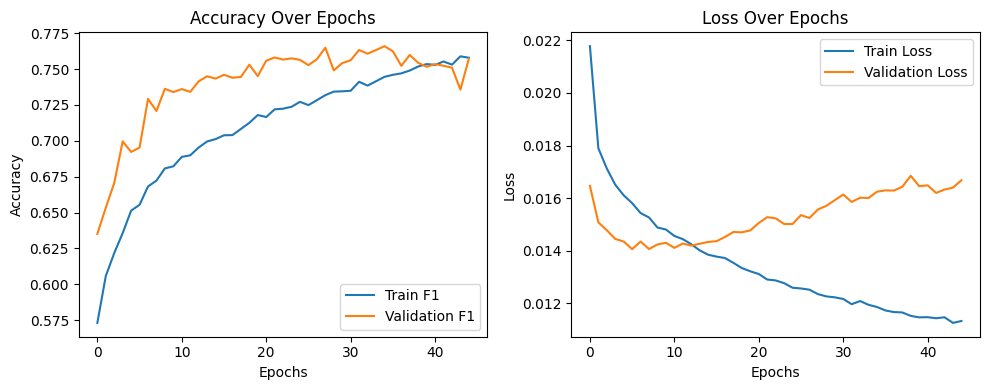

In [50]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_history.history['f1_score'], label='Train F1')
plt.plot(efficientnet_history.history['val_f1_score'], label='Validation F1')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_history.history['loss'], label='Train Loss')
plt.plot(efficientnet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Testing

In [13]:
from tensorflow.keras.models import load_model

# Ensure the custom metric F1Score is available when loading the model
custom_objects={
    'focal_loss': focal_loss(),
    'F1Score': F1Score
}
best_efficientnet_model = load_model('best_model.keras', custom_objects=custom_objects)
best_efficientnet_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 624 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_caption       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 18)        │  9,229,835 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │  3,085,312 │ input_caption[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 274)       │          0 │ functional_3[0][… │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 274)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     70,400 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 18)        │      4,626 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,035,371 (141.28 MB)

 Trainable params: 12,322,598 (47.01 MB)

 Non-trainable params: 67,575 (263.97 KB)

 Optimizer params: 24,645,198 (94.01 MB)

In [11]:
# Add image paths to the test dataframe
test_df['image_path'] = test_df['ImageID'].apply(lambda x: os.path.join(IMAGES_DIR, x))

# Preprocess and tokenize captions for the test dataset (assuming you have similar preprocessing steps)
# If you have used any specific preprocessing for captions in training, apply the same here
test_captions = test_df['Caption'].values
# Assuming you already have a tokenizer fitted on the training captions
test_captions_padded = tokenizer.texts_to_sequences(test_captions)
test_captions_padded = pad_sequences(test_captions_padded, maxlen=MAX_CAPTION_LENGTH, padding='post')
def create_tf_test_dataset(image_paths, captions):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    caption_ds = tf.data.Dataset.from_tensor_slices(captions)
    
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = tf.data.Dataset.zip((image_ds, caption_ds))
    
    def prepare_features(images, captions):
        return {'input_layer': images, 'input_caption': captions}

    return dataset.map(prepare_features, num_parallel_calls=tf.data.AUTOTUNE)

# Create TensorFlow Dataset for the test set
test_ds = create_tf_test_dataset(test_df['image_path'].values, test_captions_padded)

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds
# Optionally, configure the dataset for performance in the same way as training/validation sets
test_ds = configure_for_performance(test_ds)


In [14]:
# Make predictions
predictions = best_efficientnet_model.predict(test_ds, verbose=1)

# Assuming predictions need to be formatted into binary labels as per the competition requirement
predicted_labels = (predictions > 0.5).astype(int)

# Prepare DataFrame for submission
submission_df = pd.DataFrame({
    'ImageID': test_df['ImageID'],
    'Labels': [' '.join(map(str, (np.flatnonzero(label) + 1).tolist())) for label in predicted_labels]
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)


79/79 ━━━━━━━━━━━━━━━━━━━━ 50s 504ms/step


#### Fine Tunning

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.mixed_precision import set_global_policy

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout

# Set the mixed precision policy to mixed_float16
set_global_policy('mixed_float16')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_f1', mode='max', patience=10, restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_refined.keras', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [checkpoint, early_stopping, reduce_lr]
additional_epochs = 50

# Ensure the custom metric F1Score is available when loading the model
custom_objects = {"F1Score": F1Score}

# Load the model with custom objects
best_efficientnet_model = load_model('best_model.keras', custom_objects=custom_objects) 
# Assume you are removing the last layer and adding new layers
#x = best_efficientnet_model.layers[-2].output  # This could be the second last layer's output
functional_1_output = best_efficientnet_model.layers[-5].output
functional_3_output = best_efficientnet_model.layers[-6].output
# Add new layers
pooled_output = GlobalAveragePooling2D()(functional_3_output)
concatenated_features = Concatenate()([pooled_output, functional_1_output])

# Continue with adding new layers as planned
x = GlobalAveragePooling2D()(concatenated_features)
x = concatenated_features
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax', dtype='float32')(x)  # Ensure dtype='float32' for the final layer

# Create a new model
new_model = Model(inputs=best_efficientnet_model.input, outputs=output)
new_model.compile(optimizer='adam',
                  loss=focal_loss(),  # or another appropriate loss function
                  metrics=[F1Score()])  # Ensure F1Score is correctly implemented
# Adjust batch size if necessary, especially if using mixed precision
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

# Use the callbacks defined earlier
refine_history = new_model.fit(train_ds, validation_data=val_ds, epochs=additional_epochs, callbacks=callbacks_list)


ValueError: Input 0 of layer "global_average_pooling2d_3" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 18)

In [32]:
best_efficientnet_model.layers[-5]

<Functional name=functional_1, built=True>

In [27]:
best_efficientnet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_caption       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 18)        │  9,229,835 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │  3,085,312 │ input_caption[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 274)       │          0 │ functional_3[0][… │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 274)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     70,400 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 18)        │      4,626 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,035,375 (141.28 MB)

 Trainable params: 12,322,598 (47.01 MB)

 Non-trainable params: 67,575 (263.97 KB)

 Optimizer params: 24,645,202 (94.01 MB)

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(refine_history.history['f1_score'], label='Train F1')
plt.plot(refine_history.history['val_f1_score'], label='Validation F1')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(refine_history.history['loss'], label='Train Loss')
plt.plot(refine_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### GoogleNet

In [ ]:
K.clear_session()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3

def create_inception_model(num_classes):
    # Define the input tensor directly
    image_input = Input(shape=(256, 256, 3))

    # Construct the base model with the defined input tensor
    base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=image_input)
    base_model.trainable = False  # Optionally, freeze the base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs=image_input, outputs=predictions)

def create_combined_inception_text_model(inception_model, text_model, num_classes):
    # Directly use the tensor inputs from each model
    image_input = inception_model.input
    caption_input = text_model.input

    # Verify we're not dealing with lists
    assert not isinstance(image_input, list), "Image input should be a tensor, not a list"
    assert not isinstance(caption_input, list), "Caption input should be a tensor, not a list"

    # Process outputs from both models
    inception_output = inception_model(image_input)
    text_output = text_model(caption_input)

    # Concatenate outputs
    concatenated = Concatenate()([inception_output, text_output])

    # Additional layers after concatenation
    x = Dropout(0.5)(concatenated)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    return model

# Instantiate models
inception_model = create_inception_model(NUM_CLASSES)
text_model = create_text_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_CAPTION_LENGTH)  # Assuming this function is already defined
final_inception_model = create_combined_inception_text_model(inception_model, text_model, NUM_CLASSES)

# Compile the model
final_inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score()])
final_inception_model.summary()

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=10, restore_best_weights=True, verbose=1)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

# Train the Model
inception_history = final_inception_model.fit(
    train_ds,  # Ensure that the dataset uses the correct input names
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint]
)

In [ ]:
image_input = inception_model.input
caption_input = text_model.input

print(type(image_input))  # Should show <class 'tensorflow.python.framework.ops.Tensor'>
print(type(caption_input))  # Should show <class 'tensorflow.python.framework.ops.Tensor'>
print("Image Input:", image_input)
print("Caption Input:", caption_input)
print("Inputs List Type Check:", all(isinstance(i, tf.Tensor) for i in [image_input, caption_input]))


## ResNet

In [ ]:
num_classes = 18

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom layers for multilabel classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='sigmoid')(x)  # Sigmoid activation for multilabel
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score()])

# Model summary
#model.summary()


In [ ]:
batch_size = 128
num_epochs = 50
train_steps_per_epoch = int(np.floor(len(train_df) / batch_size))
val_steps_per_epoch = int(np.floor(len(val_df) / batch_size))

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="min")

# Now use them in your model.fit call
history = model.fit(
    x = train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch
#     callbacks=[es]
)

In [ ]:
plt.plot(history.history["accuracy"],c = "blue")
plt.plot(history.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(["train", "validation"])

In [ ]:
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["val_loss"],c = "black")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.rcParams["figure.figsize"] = (10,10)
plt.show()